In [2]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : $\beta$ accross all layers (Top-10% filters)

In [3]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)


In [ ]:
k = 10 # Top 10% highest l2-magnitude filters

In [ ]:

mixed = []
sym  =  []   #beta < .25
anti =  []  #beta > .75

model = VGG16(weights=None,
                  include_top=False,
                  input_shape=(224, 224, 3))

l_num = 10
anti.append(0)
sym.append(0)
mixed.append(0)
count = 0
print(f" ============ LAYER {l_num} ==================")
top10F=topKfilters(model, l_num, k=100)
beta_f = []
for f in top10F:
   top10C = topKchannels(model, l_num, f, k=k)

   filters = tf.expand_dims(get_filter(model, l_num)[:,:,top10C, f], -1)
   s, a = getSymAntiSymTF(filters)
   a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
   s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
   total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
   beta = a_energy/total_energy

   for b in beta:
      print(b)
      if b>=0.75:
         anti[-1]+=1
      elif b<=0.25:
         sym[-1]+=1
      else:
         mixed[-1]+=1
      count+=1

anti[-1] = anti[-1]/count
sym[-1] = sym[-1]/count
mixed[-1] = mixed[-1]/count

print(anti, sym, mixed)
print(beta.shape[0])




model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for l_num, l in enumerate(conv_layers):
    anti.append(0)
    sym.append(0)
    mixed.append(0)
    count = 0
    print(f" ============ LAYER {l_num} ==================")
    top10F=topKfilters(model, l_num, k=k)
    beta_f = []
    for f in top10F:
        top10C = topKchannels(model, l_num, f, k=k)

        filters = tf.expand_dims(get_filter(model, l_num)[:,:,top10C, f], -1)
        s, a = getSymAntiSymTF(filters)
        a_energy = reduce_euclidean_norm(a, axis=[0,1])**2
        s_energy = reduce_euclidean_norm(s, axis=[0,1])**2
        total_energy  = reduce_euclidean_norm(filters, axis=[0,1])**2
        beta = a_energy/total_energy

        for b in beta:
            print(b)
            if b>=0.75:
               anti[-1]+=1
            elif b<=0.25:
               sym[-1]+=1
            else:
               mixed[-1]+=1
            count+=1

    anti[-1] = anti[-1]/count
    sym[-1] = sym[-1]/count
    mixed[-1] = mixed[-1]/count

    print(anti, sym, mixed)
    print(beta.shape[0])




In [ ]:
len(conv_layers)

In [ ]:
(np.concatenate(([0], np.arange(2, len(conv_layers)+2, step=1))))

In [ ]:
sym.shape

In [ ]:
np.save("sym_vals", sym, allow_pickle=False)
np.save("mixed_vals", mixed, allow_pickle=False)
np.save("anti_vals", anti, allow_pickle=False)

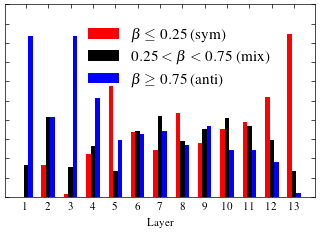

In [6]:
sym = np.load("vgg_sym_vals.npy")
mixed = np.load("vgg_mixed_vals.npy")
anti = np.load("vgg_anti_vals.npy")

x = np.arange(1, len(conv_layers)+1, step=1)

width = 0.2
plt.rcParams['figure.figsize'] = (4, 2.5)

plt.bar(x-0.2, sym[1:], width , color='r') 
plt.bar(x, mixed[1:], width, color='k') 
plt.bar(x+0.2, anti[1:], width, color='b') 

plt.xlabel("Layer") 
#plt.ylabel("\%") 
x = x.tolist()

    

plt.xticks(x)
plt.yticks(np.arange(0, 1.1, step=0.1), ['']*11)


#plt.title('R')

ticks = plt.gca().get_xticklabels()
#ticks[0].set_rotation(-90)

plt.minorticks_off()
plt.legend([r"$\beta\leq0.25$ (sym)",  r"$0.25<\beta<0.75$ (mix)", r"$\beta\geq0.75$ (anti)",], loc = 'upper right',  bbox_to_anchor=(.9,.95) , prop={'size': 11})


plt.savefig('figures/vgg16_kernel_type.pdf', dpi=600)

plt.show() 